In [161]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder


In [162]:
data = pd.read_csv('../data/FINAL_DATASET.csv')
data.set_index("id", inplace=True)
data.head()

,title,link,content,gold_label
id,,,,
0,ادارہ 'علم دوست' کی جانب سے'معلوماتِ عامہ' کے ...,https://www.express.pk/story/2733338/idara-ilm...,ادارہ 'علم دوست' کی جانب سے'معلوماتِ عامہ' کے ...,Entertainment
1,فلم ساز ودھو ونود چوپڑا کی نئی فلم ’زیرو سے ری...,https://www.express.pk/story/2733336/director-...,معروف فلم ساز ودھو ونود چوپڑا نے اپنی نئی فلم ...,Entertainment
2,عمر بڑھنے کے ساتھ وزن کم کرنا مشکل ہوتا ہے، اب...,https://www.express.pk/story/2733331/umer-barh...,ابھیشیک بچن نے اپنی نئی فلم ’آئی وانٹ ٹو ٹاک‘ ...,Entertainment
3,ملائکہ اروڑا والد کے انتقال کے بعد کام پر واپس...,https://www.express.pk/story/2733327/malaikaar...,مشہور اداکارہ ملائکہ اروڑا حال ہی میں والد کے ...,Entertainment
4,ڈائریکٹر دھرمیش درشن کا دو بار شاہ رخ خان کی ف...,https://www.express.pk/story/2733325/directord...,بالی ووڈ کے معروف ہدایتکار دھرمیش درشن نے حالی...,Entertainment


In [163]:
with open('../data/stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

def normalize_unicode(text):
    return re.sub(r'[٠١٢٣٤٥٦٧٨٩]', '', text)  # Remove Urdu numerals

def normalize_urdu(text):
    text = re.sub(r'[؁؂؃؄؅؆؇؈؉؊؋،؛؟]', '', text)  # Remove Urdu punctuation
    text = re.sub(r'[آإأٱ]', 'ا', text)  # Normalize different forms of 'alif'
    text = re.sub(r'[ىېۍ]', 'ی', text)  # Normalize different forms of 'ye'
    text = re.sub(r'[ۀہ]', 'ہ', text)  # Normalize 'heh'
    text = re.sub(r'[ؤو]', 'و', text)  # Normalize 'waw'
    text = re.sub(r'[ءئ]', 'ی', text)  # Normalize 'hamza' with 'ye'
    return text

def tokenize_text(text):
    return re.findall(r'\w+', text)  # Extract words using regex

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]

def lemmatize_custom(word):
    if word.endswith('نا') or word.endswith('تے'):
        return word[:-2]  # Strip suffix
    elif word.endswith('ا') or word.endswith('ی'):
        return word[:-1]  # Remove singular/plural suffix
    return word

def lemmatize_text(tokens):
    return [lemmatize_custom(word) for word in tokens]

def remove_non_informative_words(tokens):
    return [word for word in tokens if len(word) > 1]  # Remove single-character tokens


def preprocess_urdu_text(text):
    text = clean_text(text)  # Clean text
    text = normalize_unicode(text)  # Normalize Unicode
    text = normalize_urdu(text)  # Normalize Urdu-specific characters
    tokens = tokenize_text(text)  # Tokenize text
    tokens = remove_stopwords(tokens)  # Remove stopwords
    tokens = lemmatize_text(tokens)
    tokens = remove_non_informative_words(tokens)# Apply lemmatization
    return ' '.join(tokens)  # Return preprocessed text

# Apply preprocessing to dataset
data['title'] = data['title'].apply(preprocess_urdu_text)
data['content'] = data['content'].apply(preprocess_urdu_text)
data['combined'] = data['title'] + " " + data['content']


In [164]:
train_data, test_val_data = train_test_split(data, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

In [165]:
word_counter = Counter(" ".join(train_data["content"]).split())
vocab = [word for word, freq in word_counter.most_common(6000)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}


In [166]:
def vectorize_text(text, vocab, word_to_idx):
    vector = np.zeros(len(vocab))
    for word in text.split():
        if word in word_to_idx:
            vector[word_to_idx[word]] += 1
    return vector

train_vectors = np.array([vectorize_text(text, vocab, word_to_idx) for text in train_data["content"]])
val_vectors = np.array([vectorize_text(text, vocab, word_to_idx) for text in val_data["content"]])
test_vectors = np.array([vectorize_text(text, vocab, word_to_idx) for text in test_data["content"]])


label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data["gold_label"])
val_labels = label_encoder.transform(val_data["gold_label"])
test_labels = label_encoder.transform(test_data["gold_label"])


In [167]:
train_dataset = TensorDataset(torch.tensor(train_vectors, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(val_vectors, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_vectors, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [168]:
import torch.nn as nn

class ArticleClassifier(nn.Module):
    def __init__(self, input_dims, output_dims, dropout_prob=0.4):
        super(ArticleClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dims, 1024),  
            nn.ReLU(),                  
            nn.Linear(1024, 128),        
            nn.ReLU(),                  
            nn.Linear(128, 64),           
            nn.ReLU(),
            nn.Linear(64, 32),            
            nn.ReLU(),
            nn.Linear(32, output_dims)  
        )

    def forward(self, x):
        return self.model(x)


In [169]:
input_size = 6000
num_classes = len(label_encoder.classes_)
model = ArticleClassifier(input_size, num_classes).to("cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [170]:
# Initialize lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Calculate accuracy for this batch
        predictions = torch.argmax(outputs, dim=1)
        correct_predictions += (predictions == y_batch).sum().item()
        total_samples += y_batch.size(0)

    # Calculate epoch metrics
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_samples = 0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
            val_predictions = torch.argmax(val_outputs, dim=1)
            val_correct_predictions += (val_predictions == y_val_batch).sum().item()
            val_samples += y_val_batch.size(0)

    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_accuracy = val_correct_predictions / val_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.2%}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_accuracy:.2%}")


Epoch 1/40
  Train Loss: 1.1271 | Train Acc: 64.76%
  Val Loss:   0.3582 | Val Acc:   94.74%
Epoch 2/40
  Train Loss: 0.1167 | Train Acc: 97.94%
  Val Loss:   0.1157 | Val Acc:   96.57%
Epoch 3/40
  Train Loss: 0.0158 | Train Acc: 99.77%
  Val Loss:   0.1295 | Val Acc:   96.57%
Epoch 4/40
  Train Loss: 0.0065 | Train Acc: 99.92%
  Val Loss:   0.1021 | Val Acc:   97.48%
Epoch 5/40
  Train Loss: 0.0043 | Train Acc: 99.92%
  Val Loss:   0.1034 | Val Acc:   98.17%
Epoch 6/40
  Train Loss: 0.0033 | Train Acc: 99.92%
  Val Loss:   0.1037 | Val Acc:   97.71%
Epoch 7/40
  Train Loss: 0.0026 | Train Acc: 99.92%
  Val Loss:   0.1052 | Val Acc:   97.71%
Epoch 8/40
  Train Loss: 0.0022 | Train Acc: 99.92%
  Val Loss:   0.1070 | Val Acc:   97.48%
Epoch 9/40
  Train Loss: 0.0018 | Train Acc: 100.00%
  Val Loss:   0.1049 | Val Acc:   97.48%
Epoch 10/40
  Train Loss: 0.0016 | Train Acc: 100.00%
  Val Loss:   0.1067 | Val Acc:   97.71%
Epoch 11/40
  Train Loss: 0.0014 | Train Acc: 100.00%
  Val Loss:  

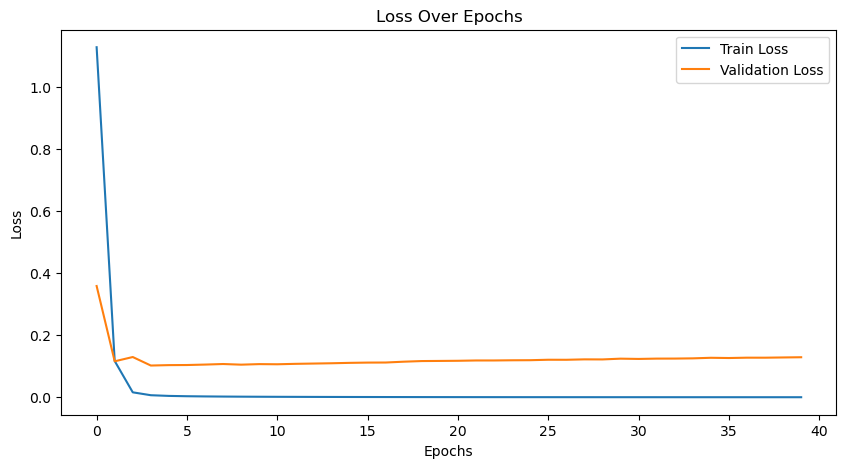

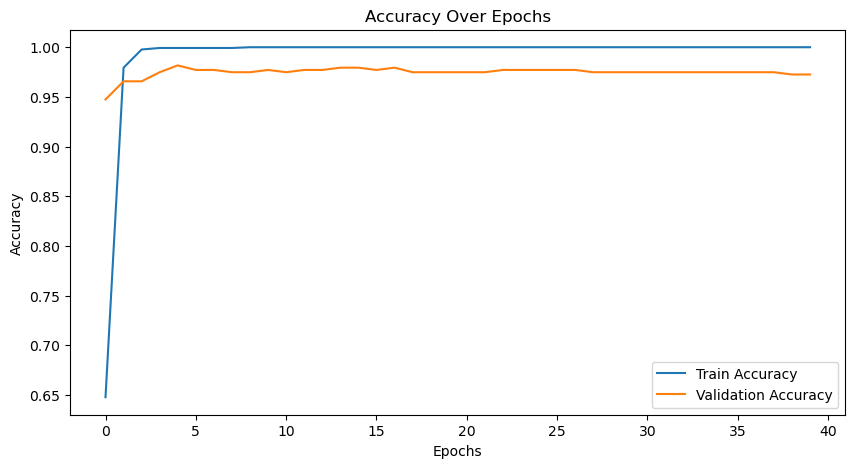

In [171]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


In [172]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    true_labels = []
    predicted_labels = []

    for X_batch, y_batch in data_loader:
        # Forward pass
        outputs = model(X_batch)
        predictions = torch.argmax(outputs, dim=1)

        # Append true and predicted labels for this batch
        true_labels.extend(y_batch.tolist())
        predicted_labels.extend(predictions.tolist())

        # Compute accuracy
        total_correct += (predictions == y_batch).sum().item()
        total_samples += y_batch.size(0)

    accuracy = total_correct / total_samples

    return accuracy, true_labels, predicted_labels


In [173]:
_,all_labels, all_preds = evaluate(model, test_loader)


In [174]:
cr = classification_report(all_labels, all_preds,output_dict=True)
cm = confusion_matrix(all_labels, all_preds)

print(cr)
print(cm)

{'0': {'precision': 0.9878048780487805, 'recall': 1.0, 'f1-score': 0.9938650306748467, 'support': 81.0}, '1': {'precision': 0.9767441860465116, 'recall': 1.0, 'f1-score': 0.9882352941176471, 'support': 84.0}, '2': {'precision': 0.9787234042553191, 'recall': 0.9583333333333334, 'f1-score': 0.968421052631579, 'support': 96.0}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768116, 'support': 68.0}, '4': {'precision': 0.9904761904761905, 'recall': 0.9629629629629629, 'f1-score': 0.9765258215962441, 'support': 108.0}, 'accuracy': 0.9816933638443935, 'macro avg': {'precision': 0.9810354460510746, 'recall': 0.9842592592592594, 'f1-score': 0.9825108890794256, 'support': 437.0}, 'weighted avg': {'precision': 0.981795709352266, 'recall': 0.9816933638443935, 'f1-score': 0.9816076309592542, 'support': 437.0}}
[[ 81   0   0   0   0]
 [  0  84   0   0   0]
 [  0   2  92   1   1]
 [  0   0   0  68   0]
 [  1   0   2   1 104]]


In [175]:
print(f"Accuracy: {cr['accuracy']:.2%}")
print(f"F1-Score: {cr['macro avg']['f1-score']:.2%}")
print(f"Recall: {cr['macro avg']['recall']:.2%}")

Accuracy: 98.17%
F1-Score: 98.25%
Recall: 98.43%
